In [55]:
import pandas as pd
import warnings
import xarray as xr
from datetime import datetime, timedelta
import math
import numpy as np
warnings.filterwarnings('ignore')
%matplotlib inline
import matplotlib.pyplot as plt

In [67]:
station = '41043'
fname = 'https://www.ndbc.noaa.gov/data/realtime2/'+station+'.txt'
#more info: https://www.ndbc.noaa.gov/station_page.php?station=41043. 10 min intervals

In [68]:
df_buoy = pd.read_csv(fname, delim_whitespace=True, header=0, parse_dates=True,na_values='MM')
#delete units row
df_buoy = df_buoy.drop(index=0)


In [69]:
df_buoy.head()

,#YY,MM,DD,hh,mm,WDIR,WSPD,GST,WVHT,DPD,APD,MWD,PRES,ATMP,WTMP,DEWP,VIS,PTDY,TIDE
1,2024,09,18,22,00,20,3.0,4.0,NaN,NaN,NaN,NaN,1011.5,29.4,30.1,26.7,NaN,-0.0,NaN
2,2024,09,18,21,50,30,3.0,4.0,1.3,8,7.2,73,1011.5,29.5,NaN,26.6,NaN,NaN,NaN
3,2024,09,18,21,40,30,3.0,4.0,1.3,NaN,7.2,73,1011.5,29.5,30.2,26.5,NaN,NaN,NaN
4,2024,09,18,21,30,30,3.0,4.0,NaN,NaN,NaN,NaN,1011.5,29.4,30.2,26.7,NaN,NaN,NaN
5,2024,09,18,21,20,40,4.0,4.0,1.2,9,6.9,81,1011.5,29.4,30.2,26.7,NaN,NaN,NaN


In [70]:

# Rename columns to match expected input for to_datetime
df_buoy.rename(columns={"#YY": "year", "MM": "month", "DD": "day", "hh": "hour", "mm": "minute"}, inplace=True)

# Combine the date and time columns into a single timestamp
df_buoy['Timestamp'] = pd.to_datetime(df_buoy[['year', 'month', 'day', 'hour', 'minute']])

df_clean_buoy = df_buoy.drop(columns=['year', 'month', 'day', 'hour', 'minute', 'DPD', 'MWD', 'PRES', 'DEWP', 'VIS', 'PTDY', 'TIDE']).drop(index=1)

In [71]:
df_clean_buoy.dtypes

WDIR                 object
WSPD                 object
GST                  object
WVHT                 object
APD                  object
ATMP                 object
WTMP                 object
Timestamp    datetime64[ns]
dtype: object

In [76]:
#reverse the data
df_reversed_clean_buoy = df_clean_buoy.iloc[::-1].reset_index(drop=True)
df_last_1800 = df_reversed_clean_buoy.tail(1800).copy()

columns_to_convert = ['WDIR', 'WSPD', 'GST', 'WVHT', 'APD', 'ATMP', 'WTMP']

# Convert specified columns to float, using 'coerce' to handle errors
df_last_1800[columns_to_convert] = df_last_1800[columns_to_convert].apply(pd.to_numeric, errors='coerce')

df_last_1800 = df_last_1800.reset_index(drop=True)
df_last_1800 = df_last_1800.interpolate(method='linear', limit_direction='both')
df_last_1800.head()

,WDIR,WSPD,GST,WVHT,APD,ATMP,WTMP,Timestamp
0,100.0,7.0,8.0,1.4,5.10,27.60,29.4,2024-09-06 08:40:00
1,100.0,8.0,9.0,1.4,5.10,27.75,29.4,2024-09-06 08:50:00
2,100.0,8.0,9.0,1.4,5.05,27.90,29.4,2024-09-06 09:00:00
3,90.0,7.0,8.0,1.4,5.00,27.90,29.4,2024-09-06 09:10:00
4,90.0,7.0,8.0,1.4,5.00,28.00,29.4,2024-09-06 09:20:00


In [77]:
df_last_1800.shape

(1800, 8)

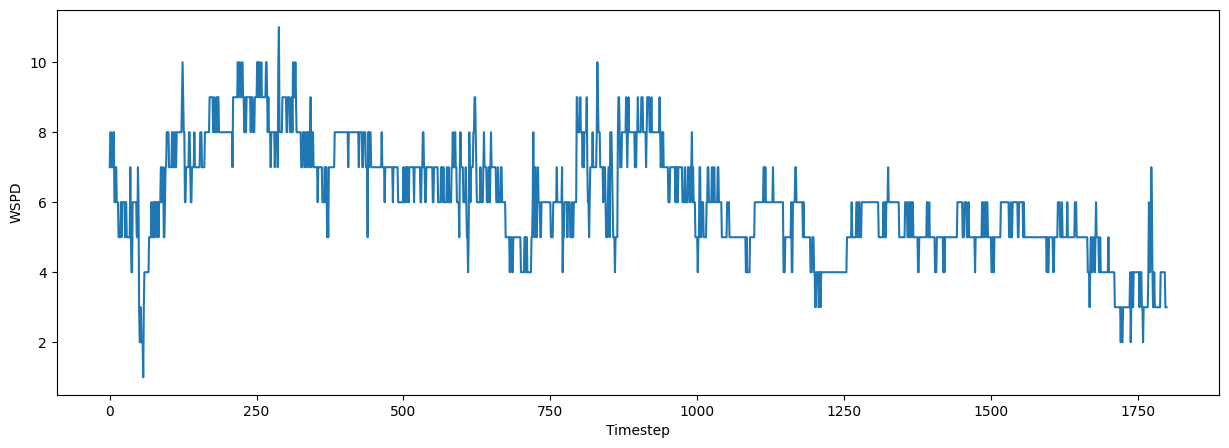

In [79]:
#graph
%matplotlib inline
import matplotlib.pyplot as plt
channel = "WSPD"
plt.figure(figsize=(15, 5))
plt.plot(df_last_1800.index,df_last_1800[channel])
plt.xlabel('Timestep')
plt.ylabel(channel)
plt.savefig("../img/buoy_1800.png")

In [99]:
#normalize and park
# Assuming 'df' is already loaded and has the 'Sample' column
# Normalize the 'Sample' column using min-max normalization
df_normalized = (df_last_1800 - df_last_1800.min()) / (df_last_1800.max() - df_last_1800.min())

# Create a new DataFrame with an index from 0 to 7199
new_df = pd.DataFrame(index=np.arange(7200))

# Fill the new DataFrame with 0.0 values initially for each column in df_last_1800
for column in df_last_1800.columns:
    new_df[column] = 0.0

# Define the start index to place df_last_1800 at index 0
start_idx = 0
# Place the data from df_last_1800 in the new DataFrame starting at 'start_idx'
new_df.loc[start_idx:start_idx + len(df_normalized) - 1, df_normalized.columns] = df_normalized.values
#again for the tail
start_idx = 5399
new_df.loc[start_idx:start_idx + len(df_normalized) - 1, df_normalized.columns] = df_normalized.values

# Display the resulting DataFrame (showing first and last 10 rows)
new_df.head(10), new_df.tail(10)

(       WDIR  WSPD       GST      WVHT       APD      ATMP      WTMP  Timestamp
 0  0.257143   0.6  0.461538  0.333333  0.323529  0.574468  0.111111   0.000000
 1  0.257143   0.7  0.538462  0.333333  0.323529  0.606383  0.111111   0.000553
 2  0.257143   0.7  0.538462  0.333333  0.308824  0.638298  0.111111   0.001107
 3  0.228571   0.6  0.461538  0.333333  0.294118  0.638298  0.111111   0.001660
 4  0.228571   0.6  0.461538  0.333333  0.294118  0.659574  0.111111   0.002214
 5  0.257143   0.6  0.538462  0.300000  0.294118  0.659574  0.111111   0.002767
 6  0.257143   0.7  0.615385  0.266667  0.294118  0.638298  0.111111   0.003320
 7  0.257143   0.7  0.538462  0.266667  0.294118  0.680851  0.111111   0.003874
 8  0.228571   0.5  0.461538  0.288889  0.323529  0.659574  0.111111   0.004427
 9  0.257143   0.5  0.384615  0.311111  0.352941  0.680851  0.111111   0.004981,
           WDIR  WSPD       GST      WVHT       APD      ATMP  WTMP  Timestamp
 7190  0.057143   0.3  0.230769  0.23333

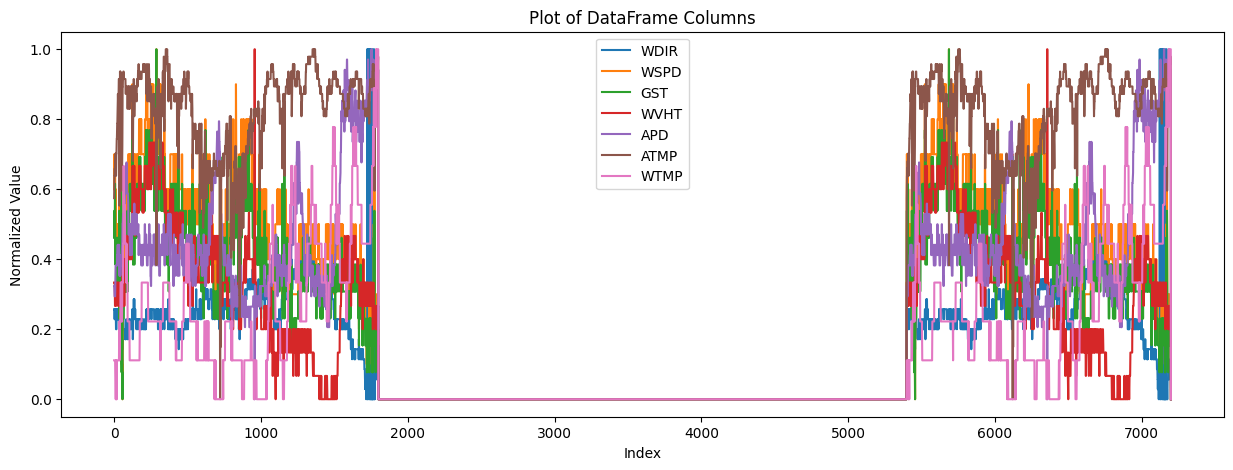

In [101]:
fig, ax = plt.subplots(figsize=(15, 5))

# Loop through each column in the DataFrame
for column_name in new_df.columns:
    if column_name != "Timestamp":# Plot the column directly
        new_df[column_name].plot(label=column_name, ax=ax)

plt.title('Plot of DataFrame Columns')
plt.ylabel('Normalized Value')
plt.xlabel('Index')
plt.legend()
plt.savefig("../img/buoy_7200.png")
plt.show()

In [102]:
new_df.to_csv("../data/buoy_7200.csv", index = True)